In [1]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# NLTK modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import re
from gensim.models import Word2Vec 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [4]:
data=pd.read_csv("/content/BBC News.csv")

In [5]:
data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


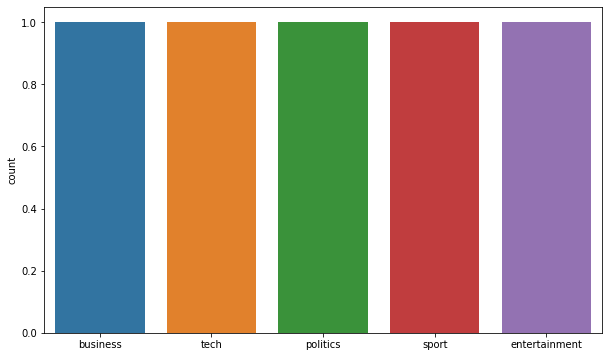

In [6]:
# Plot category data
plt.figure(figsize=(10,6))
sns.countplot(data.Category.unique())
plt.show()

In [7]:
class DataPreparation:
    def __init__(self, data, column='Text'):
        self.df = data
        self.column = column
    
    def preprocess(self):
        self.tokenize()
        self.remove_stopwords()
        self.remove_non_words()
        self.lemmatize_words()
        return self.df
    
    def tokenize(self):
        self.df['clean_text'] = self.df[self.column].apply(nltk.word_tokenize)
        print("Tokenization is done.")
    
    def remove_stopwords(self):
        stopword_set = set(nltk.corpus.stopwords.words('english'))
        
        rem_stopword = lambda words: [item for item in words if item not in stopword_set]
        self.df['clean_text'] = self.df['clean_text'].apply(rem_stopword)
        print("Remove stopwords done.")
    
    def remove_non_words(self):
        """
            Remove all non alpha characters from the text data
            :numbers: 0-9
            :punctuation: All english punctuations
            :special characters: All english special characters
        """
        regpatrn = '[a-z]+'
        rem_special_chars = lambda x: [item for item in x if re.match(regpatrn, item)]
        self.df['clean_text'] = self.df['clean_text'].apply(rem_special_chars)
        print("Removed non english characters is done.")
        
    def lemmatize_words(self):
        lemma = nltk.stem.wordnet.WordNetLemmatizer()
        on_word_lemma = lambda x: [lemma.lemmatize(w, pos='v') for w in x]
        
        self.df['clean_text'] = self.df['clean_text'].apply(on_word_lemma)
        print("Lemmatization on the words.")

In [8]:
data_prep = DataPreparation(data)
cleanse_df = data_prep.preprocess()


Tokenization is done.
Remove stopwords done.
Removed non english characters is done.
Lemmatization on the words.


In [9]:
cleanse_df['clean_text']

0       [worldcom, ex-boss, launch, defence, lawyers, ...
1       [german, business, confidence, slide, german, ...
2       [bbc, poll, indicate, economic, gloom, citizen...
3       [lifestyle, govern, mobile, choice, faster, be...
4       [enron, boss, payout, eighteen, former, enron,...
                              ...                        
1485    [double, eviction, big, brother, model, capric...
1486    [dj, double, act, revamp, chart, show, dj, duo...
1487    [weak, dollar, hit, reuters, revenues, media, ...
1488    [apple, ipod, family, expand, market, apple, e...
1489    [santy, worm, make, unwelcome, visit, thousand...
Name: clean_text, Length: 1490, dtype: object

In [10]:
vec_model = Word2Vec(cleanse_df['clean_text'])

w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.syn0))

In [11]:
class Vectorizer(object):
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])
    

    

In [12]:
# Classifier class
class Classifier(object):
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gsearch = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)
        
    def fit(self, X, y):
        return self.gsearch.fit(X, y)
    
    def predict(self, X):
        return self.gsearch.predict(X)

In [13]:
clf_models = {
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
    'Perceptron': MLPClassifier()
}

clf_params = {
    'Naive Bayes': {},
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
    'Perceptron': {'activation': ['tanh', 'relu']}
}

In [14]:
#splitting the dataset
X_train, X_valid, y_train, y_valid = train_test_split(cleanse_df['clean_text'], cleanse_df['Category'], test_size=0.2, shuffle=True)

In [15]:
# Iterate through the model names
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    # Fitting the data
    clf.fit(X_train, y_train)
    
    y_preds = clf.predict(X_valid)
    
    
    print(key, ":")
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_valid, y_preds),
                                                                                                                                                                          precision_score(y_valid, y_preds, average='macro'),
                                                                                     recall_score(y_valid, y_preds, average='macro'),
                                                                                     f1_score(y_valid, y_preds, average='macro')))

Naive Bayes :
Accuracy: 0.876 	Precision: 0.874 	Recall: 0.876 	F1-Score: 0.873

SVC :
Accuracy: 0.909 	Precision: 0.908 	Recall: 0.906 	F1-Score: 0.906

Decision Tree :
Accuracy: 0.879 	Precision: 0.877 	Recall: 0.878 	F1-Score: 0.877

SGD Classifier :
Accuracy: 0.906 	Precision: 0.908 	Recall: 0.905 	F1-Score: 0.905

Perceptron :
Accuracy: 0.926 	Precision: 0.925 	Recall: 0.923 	F1-Score: 0.924

